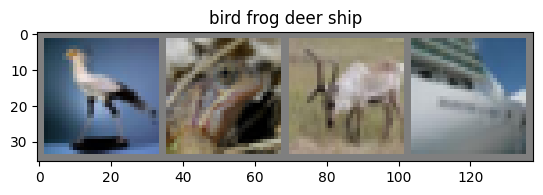

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import random

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full train and test datasets
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Sample 8000 from train, 2000 from test
train_indices = random.sample(range(len(full_trainset)), k=8000)
test_indices = random.sample(range(len(full_testset)), k=2000)

trainset = Subset(full_trainset, train_indices)
testset = Subset(full_testset, test_indices)

trainloader = DataLoader(trainset, batch_size=4, shuffle=True)
testloader = DataLoader(testset, batch_size=4, shuffle=True)

# Get one batch
images, labels = next(iter(trainloader))

# Show images
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0) / 2 + 0.5)
plt.title(' '.join(full_trainset.classes[label] for label in labels))
plt.show()

In [22]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [23]:
import torch.optim as optim
import torch.nn.functional as F

model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch} loss: {running_loss / len(trainloader)}')

Epoch 0 loss: 1.9167944068610667
Epoch 1 loss: 1.4998306746333838
Epoch 2 loss: 1.269419169701636
Epoch 3 loss: 1.0620137386247515
Epoch 4 loss: 0.8830550343580544
Epoch 5 loss: 0.6967010166747496
Epoch 6 loss: 0.5346721771545708
Epoch 7 loss: 0.3935314945556456
Epoch 8 loss: 0.2766124234163726
Epoch 9 loss: 0.20599461379327114


F1 Score (Macro): 0.6075
F1 Score (Weighted): 0.6034


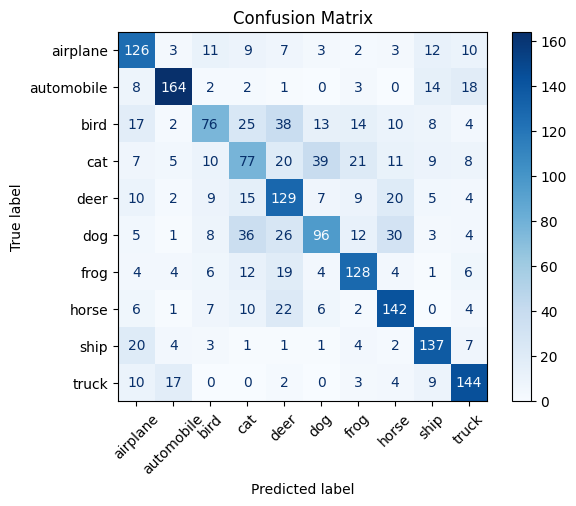

In [24]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute F1 Scores
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_testset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [27]:
import torch
import torch.nn.functional as F

class JaccardLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super(JaccardLoss, self).__init__()
        self.eps = eps

    def forward(self, outputs, targets):
        num_classes = outputs.shape[1]
        # One-hot encode targets
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float() \
            if outputs.dim() == 4 else F.one_hot(targets, num_classes).float()

        outputs = F.softmax(outputs, dim=1)

        intersection = (outputs * targets_one_hot).sum(dim=0)
        union = (outputs + targets_one_hot - outputs * targets_one_hot).sum(dim=0)
        iou = (intersection + self.eps) / (union + self.eps)

        return 1 - iou.mean()

In [28]:
import torch.optim as optim
import torch.nn.functional as F

model = ResNet18()
criterion = JaccardLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch} loss: {running_loss / len(trainloader)}')

Epoch 0 loss: 0.9284386284947396
Epoch 1 loss: 0.8857185361385346
Epoch 2 loss: 0.8702374242544174
Epoch 3 loss: 0.8523152400553227
Epoch 4 loss: 0.8443713018596173
Epoch 5 loss: 0.8312156707942486
Epoch 6 loss: 0.8259868246316909
Epoch 7 loss: 0.8224860247075557
Epoch 8 loss: 0.7704240899384022
Epoch 9 loss: 0.7425817210376263


F1 Score (Macro): 0.4945
F1 Score (Weighted): 0.4909


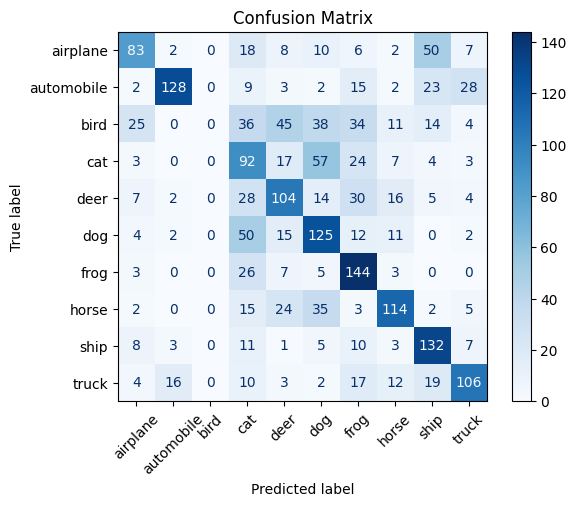

In [29]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute F1 Scores
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_testset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()